<h1>Homework 04 - Applied ML</h1>

Importation of libraries

In [5]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import datetime
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.model_selection import KFold
from sklearn import metrics
import matplotlib.pyplot as plt
from functools import reduce
import math
from collections import Counter

Importation of the datas

In [6]:
filename = os.path.join('data','CrowdstormingDataJuly1st.csv') 
df = pd.read_csv(filename)
df.head(2)

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,...,rater2,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp
0,lucas-wilchez,Lucas Wilchez,Real Zaragoza,Spain,31.08.1983,177.0,72.0,Attacking Midfielder,1,0,...,0.50,1,1,GRC,0.326391,712.0,0.000564,0.396000,750.0,0.002696
1,john-utaka,John Utaka,Montpellier HSC,France,08.01.1982,179.0,82.0,Right Winger,1,0,...,0.75,2,2,ZMB,0.203375,40.0,0.010875,-0.204082,49.0,0.061504


A few numbers about the data:

In [7]:
print('Number of dyads (rows in dataframe): ', len(df))
print('Total number of interactions between a referee and a player (nb of games): ', sum(df.games))
print('Mean number of games for a dyad: ', np.mean(df['games']))

Number of dyads (rows in dataframe):  146028
Total number of interactions between a referee and a player (nb of games):  426572
Mean number of games for a dyad:  2.92116580382


## Data cleaning / setup

In [8]:
print("Number of rows in dataframe: ", len(df))

Number of rows in dataframe:  146028


<b>Removing raters</b>: We decided to remove row where the two rates were significantly different or if any of the rates were absent (Nan value).

In [9]:
cleandf = df.copy()

## Removing null values in raters
cleandf = cleandf[cleandf["rater1"].notnull() & cleandf["rater2"].notnull()]

## Removing all rows where the difference between the two raters is larger than 0.25
cleandf['difference'] = abs(cleandf.rater1 - cleandf.rater2)
cleandf = cleandf[cleandf['difference'] <= 0.25]
cleandf.drop('difference', axis =1, inplace=True)

print("Number of rows in the cleaned dataframe: ", len(cleandf))
print("Number of rows removed: ", (len(df)-len(cleandf)))

Number of rows in the cleaned dataframe:  124457
Number of rows removed:  21571


<b>Skin tone</b>: Then we decide to take the skin tone as the mean between the two raters. This is the value that will be predicted later.

In [10]:
cleandf["meanSkinTone"] = abs(cleandf["rater1"] + cleandf["rater2"] ) / 2
cleandf.head(2)

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,...,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp,meanSkinTone
0,lucas-wilchez,Lucas Wilchez,Real Zaragoza,Spain,31.08.1983,177.0,72.0,Attacking Midfielder,1,0,...,1,1,GRC,0.326391,712.0,0.000564,0.396000,750.0,0.002696,0.375
1,john-utaka,John Utaka,Montpellier HSC,France,08.01.1982,179.0,82.0,Right Winger,1,0,...,2,2,ZMB,0.203375,40.0,0.010875,-0.204082,49.0,0.061504,0.750


<b>Birthday date</b>: As the classifier can not understand date, we decided to change birthday date in seconds. It seemed important for us to keep the birthday date, as it could help predict the color skin if there were more people from a certain demography that played during some years.

In [11]:
def time_to_seconds(t):
    seconds = (pd.to_datetime(t) - datetime.datetime(1970, 1,1)).total_seconds()
    return int(seconds)

cleandf.birthday = cleandf.birthday.apply(time_to_seconds)
cleandf.head(2)

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,...,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp,meanSkinTone
0,lucas-wilchez,Lucas Wilchez,Real Zaragoza,Spain,431136000,177.0,72.0,Attacking Midfielder,1,0,...,1,1,GRC,0.326391,712.0,0.000564,0.396000,750.0,0.002696,0.375
1,john-utaka,John Utaka,Montpellier HSC,France,397008000,179.0,82.0,Right Winger,1,0,...,2,2,ZMB,0.203375,40.0,0.010875,-0.204082,49.0,0.061504,0.750


<h3>Changing data attributes to numerals function</h3>

<i>Dummy variables</i>: We noticed that a lot of the columns could not be used in the Random forest as they are non-numerical. As most of these features can be seen as categorical variables, we decided to make dummy variables with them.

In [12]:
print("The number of different positions is", cleandf["position"].unique().size)
print("The number of different clubs is",cleandf["club"].unique().size)
print("The number of different league countries is",cleandf["leagueCountry"].unique().size)
print("The number of different referee countries is",cleandf["Alpha_3"].unique().size)

The number of different positions is 13
The number of different clubs is 97
The number of different league countries is 4
The number of different referee countries is 160


Out of these datas, we decided to remove the "referee country" (Alpha_3) and to make dummy variables with the 3 other categories. We decided to remove the referee country because there were a lot of them and it seemed it would induce more error and overfitting to our classifier than it would help it.

<i>Replacing Nan</i>: We also realize that the dataframe still have some NaN values. We decided to substitute every NaN with the mean of their column.

In [13]:
cleandf.isnull().values.any()

True

Here is the function that will apply these changes:

In [14]:
def changeDfAttributesToNumerals(cleandf):
    ## Making the dummy variables
    dummydf = pd.get_dummies(cleandf, prefix=None, prefix_sep='_', dummy_na=False, columns=["position"], sparse=False, drop_first=False)
    dummydf = pd.get_dummies(dummydf, prefix=None, prefix_sep='_', dummy_na=False, columns=["club"], sparse=False, drop_first=False)
    dummydf = pd.get_dummies(dummydf, prefix=None, prefix_sep='_', dummy_na=False, columns=["leagueCountry"], sparse=False, drop_first=False)
    dummydf.drop("Alpha_3", axis = 1, inplace = True)
    
    ## Replacing NaN values
    # For each column, if there is any NaN value, we compute the mean and replace the NaN values with it.
    for i in range(len(dummydf.columns)):
        if (dummydf[dummydf.columns[i]].isnull().values.any()):
            mean = np.mean(dummydf[dummydf.columns[i]])
            dummydf[dummydf.columns[i]].fillna(mean, inplace = True)
    
    return dummydf

We can now apply the function to our dataset and observe the results:

In [15]:
dummydf = changeDfAttributesToNumerals(cleandf)
print("Number of columns in the previous dataframe: ",cleandf.columns.size)
print("Number of columns in the new dataframe with dummy variables: ",dummydf.columns.size)

Number of columns in the previous dataframe:  29
Number of columns in the new dataframe with dummy variables:  138


In [16]:
dummydf.isnull().values.any()

False

<b>Removing useless columns</b>: For the classifier, there are some columns that it makes no sense to use. These columns are the player name (and short name), the photo and the initial ratings (of rater 1 and 2). Therefore we will drop them.

In [17]:
usedf = dummydf.drop(['playerShort', 'player', 'photoID', 'rater1', 'rater2']  , axis=1)

In [18]:
usedf.head(3)

,birthday,height,weight,games,victories,ties,defeats,goals,yellowCards,yellowReds,...,club_Werder Bremen,club_West Bromwich Albion,club_West Ham United,club_Wigan Athletic,club_Wolverhampton Wanderers,club_Évian Thonon Gaillard,leagueCountry_England,leagueCountry_France,leagueCountry_Germany,leagueCountry_Spain
0,431136000,177.0,72.0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,397008000,179.0,82.0,1,0,0,1,0,1,0,...,0,0,0,0,0,0,0,1,0,0
5,303177600,182.0,71.0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0


## Classifier

First, we executed the random forest classification algorithm.

We decided to go with multiclass classification. As it was asked to predict the skin color, this looked like it was going to be the most interesting way of observing the classification. Of course, this implies that the error will be a lot larger than in the case of binary classification.

In the following part, we built a function that executed random forest. It directly does the kfold validation with a decided K = 5. This looked enough to test it and not have a running time that was too long. Of course this value could be augmented for more precise result, but we didn't see a big enough difference that it seemed worth it.

To compute the score, we decided to go with a simple accuracy score. We didn't implement our own scoring function, but this should be adapted to f1 score (for example) in case of binary class, to equilibrate with the number of sample that we have for each data

We have different parameters:<br>
X: The data that will try to fit<br>
y: The row that contains the meanSkinColor, that we will try to fit as best as possible<br>
Xpd: The dataframe containing X<br>
printingInfo: boolean if we want to print information<br>
numb_trees: A parameter of the random forest classification that we will vary. It contains the number of trees that we want to use in our algorithm.<br>
nb_features: A parameter of the random forest classification that we will vary. It contains the maximum number of features to we want to use.

In [19]:

def executingRandomForest(X, y, Xpd, printingInfo, numb_trees, nb_features):
    # Creating kfolds
    once = True
    kf = KFold(n_splits=5, shuffle=True, random_state=1)
    sumAccurancy_tr = 0
    sumAccurancy_te = 0

    #Iterating for kfold validation
    for train_index, test_index in kf.split(X):
        if(once):
            print("Train/Test sample sizes:", train_index.size, " / ", test_index.size)

        ## Making indices
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        #Make classifier
        rf = RandomForestClassifier(n_estimators = numb_trees, max_features = nb_features, n_jobs = 4)

        #Train the classifier
        clf = rf.fit(X_train, y_train)

        # Make prediction for testing data with the classifier
        y_pred = clf.predict(X_test)

        #Computing error
        rf_train_score = metrics.accuracy_score(y_train, clf.predict(X_train))
        rf_test_score = metrics.accuracy_score(y_test, y_pred)
        if(printingInfo):
            print('Train/Test:  {:.4f} / {:.4f}'.format(rf_train_score, rf_test_score))
#             print('   {:.4f}'.format(rf_test_score))
        
        sumAccurancy_tr = sumAccurancy_tr + rf_train_score
        sumAccurancy_te = sumAccurancy_te + rf_test_score


        # Features importance score
        if(once):
            once = False
            importances = rf.feature_importances_
            std = np.std([tree.feature_importances_ for tree in rf.estimators_],
                         axis=0)
            indices = np.argsort(importances)[::-1]

    #Printing the final result score:
    print('=> Final Train/Test:  {:.4f} / {:.4f}'.format(sumAccurancy_tr / 5.0, sumAccurancy_te / 5.0))
    
    if(printingInfo):
        # Plot the feature importances of the forest
        fig = plt.figure()
        plt.title("Feature importances")
        plt.bar(range(X.shape[1]), importances[indices],
                   color="r", yerr=std[indices], align="center")
        plt.xticks(range(X.shape[1]), importances[indices])
        plt.xlim([-1, X.shape[1]])
        plt.show()

        # Print the feature ranking
        print("Feature ranking (first 20):")
        for f in range(20):
            print("%d. feature %s (%f)" % (f + 1, Xpd.columns[f], importances[indices[f]]))
        
    # Returns the average accurancy for the testing set and the training set
    return (sumAccurancy_tr / 5.0, sumAccurancy_te / 5.0)

This function takes a dataframe, and will make all the parameters that are needed in the random forest function.<br>
<i>X (the features to use in the classifier) and Y (the value to predict).</i>

In [25]:
def makeMatrixForClassifier(df):
    y = np.asarray(df["meanSkinTone"].values, dtype="|S6")
    Xpd = df.drop("meanSkinTone", axis = 1)
    X = Xpd.as_matrix()
    return (X, y, Xpd)

We will execute a first time the algorithm:

Train/Test sample sizes: 99565  /  24892
Train/Test:  0.9999 / 0.9908
Train/Test:  0.9999 / 0.9892
Train/Test:  0.9999 / 0.9879
Train/Test:  0.9998 / 0.9889
Train/Test:  0.9999 / 0.9892
=> Final Train/Test:  0.9999 / 0.9892


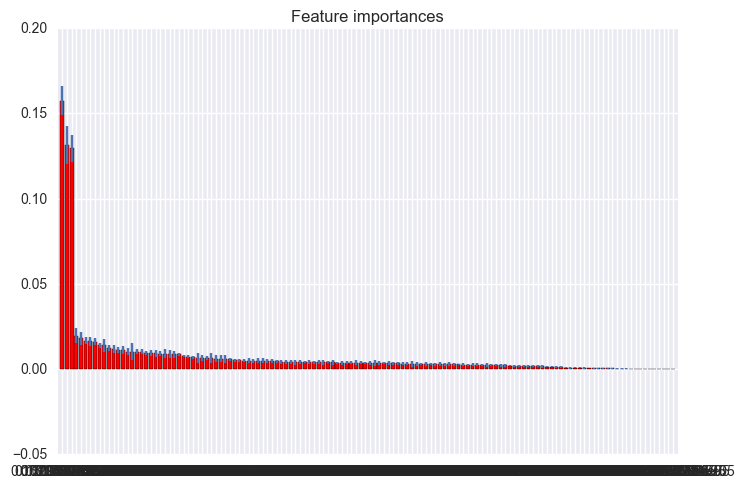

Feature ranking (first 20):
1. feature birthday (0.157238)
2. feature height (0.131284)
3. feature weight (0.129497)
4. feature games (0.019588)
5. feature victories (0.017965)
6. feature ties (0.016595)
7. feature defeats (0.016234)
8. feature goals (0.016062)
9. feature yellowCards (0.013912)
10. feature yellowReds (0.013824)
11. feature redCards (0.012351)
12. feature refNum (0.011675)
13. feature refCountry (0.011220)
14. feature meanIAT (0.011083)
15. feature nIAT (0.010234)
16. feature seIAT (0.010217)
17. feature meanExp (0.010185)
18. feature nExp (0.010129)
19. feature seExp (0.009556)
20. feature position_Attacking Midfielder (0.009376)


(0.99986541550152919, 0.98918500700334511)

In [ ]:
numb_trees = 10
nb_features = "auto"
(X, y, Xpd) = makeMatrixForClassifier(usedf)
executingRandomForest(X, y, Xpd, True, numb_trees, nb_features)

We can observe that we have unrealistic results. 99% accuracy for both training and testing sets seem too good to be true. When we look at the features importance result, we can quickly see what went wrong. The 3 most important features are the birthday, the height and the weight. It makes sense, because what is actually happening, is that the classifier has more than one line per person. Therefore, as a person has always the same skin color, recognizing the person leads to know its skin color.<br>
The testing set also has amazing result, as there are enough data of person to find them in both sets. Let's try to see if we can correct this by removing the main features.

In [ ]:
betterResultMaybedf = usedf.drop(['birthday', 'height', 'weight']  , axis=1)
(X, y, Xpd) = makeMatrixForClassifier(betterResultMaybedf)
executingRandomForest(X, y, Xpd, True, numb_trees, nb_features)

Train/Test sample sizes: 99565  /  24892
Train/Test:  0.9725 / 0.7015
Train/Test:  0.9722 / 0.6981
Train/Test:  0.9728 / 0.7031
Train/Test:  0.9720 / 0.7089


We can observe that the result is a bit worse for the testing data, as the algorithm has more trouble to "recognize" players. However, the real problem remains, and we will therefore need to find a way to group the players together. What we will want at the end, is to have a single player per line, with aggregated data in its fields. Let's see how we are going to do this.

## Aggregate the referee info by socker player

We found that there were different ways that we will aggregate the data. And, in order to aggregate the referee info, we preprocessed the data in the following way:

<ul>
<li> One occurrence data - the data that doesn't change (constants): <b>const_columns</b></li>
<li> Accumulated data - e.g. victories, yellowCards, etc. :
<b>acc_columns</b></li>
<li> Majority voting - most frequent data:
<b>majority_vote</b></li>
<li> Removed data - insignificant columns:
<b>remove_columns</b></li>

In [23]:
acc_columns = ['games', 'victories', 'ties', 'defeats', 'goals', 'yellowCards', 'yellowReds', 'redCards']
const_columns = ['playerShort', 'player', 'birthday', 'height', 'weight', 'meanSkinTone']
majority_vote = ['club', 'leagueCountry', 'position']

In [24]:
# we remove rater1 and rater2 because we already have calculated 'meanSkinTone' as the mean between those two raters
remove_columns = ['photoID', 'refNum', 'refCountry', 'Alpha_3', 'rater1', 'rater2']
referee_info_df = cleandf.drop(remove_columns, axis = 1)

#### After cleaning up, we group the data by player short name

In [44]:
by_group_player = list(referee_info_df.groupby('playerShort'))

In [45]:
# auxiliary function used in order to accumulate values for columns in 'acc_columns'
sum_func = lambda x, y: x+y
def accumulate(series):
    return reduce(sum_func, series)

<h3> Direct aggregation of data</h3>

We have the function to compute the weight. We can observe that the IAT and Exp scores are computed using statistical formulas weighted by the number of samples.

In [27]:
# Having various means, we want to combine - so we average them via calculating weighted mean 
# (the weight is the sample size)

def get_weighted_mean(data):
    
    # weighted mean calculation for meanIAT
    acc_niat = accumulate(data['nIAT'].tolist())
    acc_prod_iat = accumulate((data['meanIAT']*data['nIAT']).tolist())
    
    # weighted mean calculation for meanExp
    acc_nexp = accumulate(data['nExp'].tolist())
    acc_prod_exp = accumulate((data['meanExp']*data['nExp']).tolist())
    
    # squareroot of weighted mean of the square for seIAT
    acc_se_iat =accumulate((data['nIAT']).tolist())
    acc_prod_se_iat = accumulate((data['seIAT']*data['seIAT']*data['nIAT']).tolist())
    
    # squareroot of weighted mean of the square for seExp
    acc_se_exp =accumulate((data['nExp']).tolist())
    acc_prod_se_exp = accumulate((data['seExp']*data['seExp']*data['nExp']).tolist())
    
    return {'weighted_mean_iat' : acc_prod_iat/acc_niat,
              'weighted_mean_exp' : acc_prod_exp/acc_nexp,
              'sqrt_weighted_mean_iat' : math.sqrt(acc_prod_se_iat/acc_se_iat),
              'sqrt_weighted_mean_exp' : math.sqrt(acc_prod_se_iat/acc_se_iat)}

We execute the aggregation functions.

In [26]:
# we aggregate data in the format of 'list[dict()]' in order to create DataFrame
unique_player_data = [] 

# iterating over the grouped by plater data we assemble all processed values into the dictionary - a row within
# an out DataFrame
for player_name, data in by_group_player:
    
    # constants - we keep just first value from every column
    one_occurrence = { column : data[column].tolist()[0] for column in const_columns }
    
    #accumulated values
    accumulated = {column : accumulate(data[column].tolist()) for column in acc_columns}
    
    # majority voting = most_common() gives descending ordered by count, list of pairs;
    # most_common()[0][0] - first 0 stands for max voted value ('name': count)
    #                       second 0 gives it's name - first element from tuple 
    majority_vote = { column : Counter(data[column].tolist()).most_common()[0][0] for column in majority_vote}

    # weighted mean calculation
    wm = get_weighted_mean(data)
    
    # assemble just calculated data into one dictionary
    unique_player_data.append(
        dict(list(one_occurrence.items()) +
             list(accumulated.items()) +
             list(majority_vote.items()) +
             list(wm.items())))

In [49]:
# create DataFrame from aggregated data
aggregated_df = pd.DataFrame(unique_player_data)

We clean again the datas:

In [50]:
aggregated_df = pd.get_dummies(aggregated_df, prefix=None, prefix_sep='_', dummy_na=False, columns=["position"], sparse=False, drop_first=False)
aggregated_df = pd.get_dummies(aggregated_df, prefix=None, prefix_sep='_', dummy_na=False, columns=["club"], sparse=False, drop_first=False)
aggregated_df = pd.get_dummies(aggregated_df, prefix=None, prefix_sep='_', dummy_na=False, columns=["leagueCountry"], sparse=False, drop_first=False)
randomForestDF = aggregated_df.drop(['player', 'playerShort'], axis = 1)
# For each column, if there is any NaN value, we compute the mean and replace the NaN values with it.
for i in range(len(randomForestDF.columns)):
    if (randomForestDF[randomForestDF.columns[i]].isnull().values.any()):
        mean = np.mean(randomForestDF[randomForestDF.columns[i]])
        randomForestDF[randomForestDF.columns[i]].fillna(mean, inplace = True)
randomForestDF.isnull().values.any()

False

<b>New execution:</b> Now, we can execute again the classifier with the new datas.

Train/Test sample sizes: 1266  /  317
Train/Test:  0.9818 / 0.2965
Train/Test:  0.9842 / 0.3060
Train/Test:  0.9866 / 0.3060
Train/Test:  0.9850 / 0.3101
Train/Test:  0.9921 / 0.3386
=> Final Train/Test:  0.9859 / 0.3115


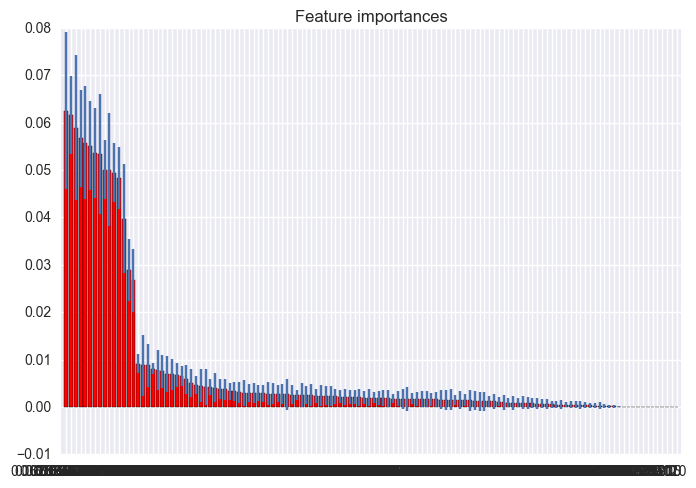

Feature ranking (first 20):
1. feature birthday (0.062524)
2. feature defeats (0.061659)
3. feature games (0.058956)
4. feature goals (0.056684)
5. feature height (0.055796)
6. feature redCards (0.055178)
7. feature sqrt_weighted_mean_exp (0.053636)
8. feature sqrt_weighted_mean_iat (0.053398)
9. feature ties (0.050097)
10. feature victories (0.050071)
11. feature weight (0.049486)
12. feature weighted_mean_exp (0.048338)
13. feature weighted_mean_iat (0.039772)
14. feature yellowCards (0.028944)
15. feature yellowReds (0.026716)
16. feature position_Attacking Midfielder (0.009109)
17. feature position_Center Back (0.008766)
18. feature position_Center Forward (0.008756)
19. feature position_Center Midfielder (0.008095)
20. feature position_Defensive Midfielder (0.007737)


(0.98594358431492835, 0.31145030547458374)

In [51]:
(X, y, Xpd) = makeMatrixForClassifier(randomForestDF)
executingRandomForest(X, y, Xpd, True, numb_trees, nb_features)

We can observe that we overfit, however the results seem much more realistic. We get 30% for the testing set, which seems good considering that we have 9 classes. The only strange part is the feature "birthday" that goes on top but it is not something we want.

Train/Test sample sizes: 1266  /  317
Train/Test:  0.9858 / 0.2997
Train/Test:  0.9818 / 0.3028
Train/Test:  0.9850 / 0.3218
Train/Test:  0.9818 / 0.2500
Train/Test:  0.9842 / 0.3038
=> Final Train/Test:  0.9837 / 0.2956


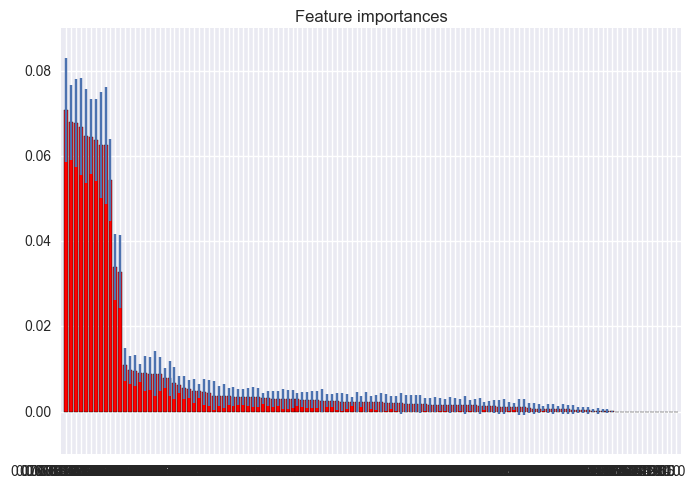

Feature ranking (first 20):
1. feature defeats (0.070702)
2. feature games (0.067851)
3. feature goals (0.067611)
4. feature redCards (0.066849)
5. feature sqrt_weighted_mean_exp (0.064694)
6. feature sqrt_weighted_mean_iat (0.064536)
7. feature ties (0.063678)
8. feature victories (0.062634)
9. feature weighted_mean_exp (0.062467)
10. feature weighted_mean_iat (0.054343)
11. feature yellowCards (0.033958)
12. feature yellowReds (0.032861)
13. feature position_Attacking Midfielder (0.011055)
14. feature position_Center Back (0.009774)
15. feature position_Center Forward (0.009630)
16. feature position_Center Midfielder (0.009121)
17. feature position_Defensive Midfielder (0.009007)
18. feature position_Goalkeeper (0.008936)
19. feature position_Left Fullback (0.008924)
20. feature position_Left Midfielder (0.008817)


(0.9837336395635472, 0.29561753783492395)

In [52]:
newRandomForestDF = randomForestDF.drop(['birthday', 'height', 'weight']  , axis=1)
(X, y, Xpd) = makeMatrixForClassifier(newRandomForestDF)
executingRandomForest(X, y, Xpd, True, numb_trees, nb_features)

We observe no improvement of the score, however the features selection look more realistic.

### Number of features effect

In [ ]:
nb_features = len(randomForestDF.columns)
nb_trees = 200

In [ ]:
# Very long to run, BE CAREFUL
training = []
testing = []

for i in range(10, nb_trees, 10):
    tr, te = executingRandomForest(X, y, Xpd, False, i, "auto")
    training.append(tr)
    testing.append(te)

In [ ]:
del training[:]
del testing[:]

for i in range(1, nb_features, 10):
    tr, te = executingRandomForest(X, y, Xpd, False, 10, i)
    training.append(tr)
    testing.append(te)

## Text to adapt....

As we can obsrved above, the number of trees created by the randm Froest Classifier is proportional to the overfitting of our model. It can be explained by the fact that more trees implies a biggest complexity of our model and so the model overfits.

By default, the numbers of featurs reached is the square root of the number of column (here it is sqrt(133) =~ 11). With a lowest number, the accurancy of our model on the testing set decreases, so a lowest number of feature reduces the overfitting.

In [ ]:
(X, y, Xpd) = makeMatrixForClassifier(randomForestDF)

y = y.astype(float)
for i in range(len(y)):
    if (y[i] <= 0.5):
        y[i] = 1
    else:
        y[i] = 0

def clustering(X, y):        
    kmeans = KMeans(n_clusters=2, random_state=0)
    y_pred = kmeans.fit_predict(X)
    
    f1score = metrics.f1_score(y, y_pred)
    print('Score f1_score: {:.5f}'.format(f1score))
    score = metrics.accuracy_score(y, y_pred)
    print('Score accuracy_score: {:.5f}'.format(1-score))
    return f1score

# clustering(X,y)

In [ ]:
cols = []

kmeansDF = randomForestDF.copy()
(X, y, Xpd) = makeMatrixForClassifier(kmeansDF)

y = y.astype(float)
for i in range(len(y)):
    if (y[i] <= 0.5):
        y[i] = 1
    else:
        y[i] = 0

scores = []
for i in range(randomForestDF.columns.size - 1):
    print(i, ': ', Xpd.columns[i])
    kmeansTemp = Xpd.drop(Xpd.columns[i], axis=1)
    X = kmeansTemp.as_matrix()
    sc = clustering(X,y)
    scores.append(sc)
